Initial full dataset size: (431371, 79)
Size after removing missing values/duplicates: (426322, 79)
Isolation Forest:
anomaly
 1    383689
-1     42633
Name: count, dtype: int64

[Initial Model] Confusion Matrix (Rows: True, Columns: Predicted):
[[ 74958  19992]
 [308731  22641]]

[Initial Model] Classification Report:
              precision    recall  f1-score   support

  Benign (1)       0.53      0.07      0.12    331372
 Attack (-1)       0.20      0.79      0.31     94950

    accuracy                           0.23    426322
   macro avg       0.36      0.43      0.22    426322
weighted avg       0.46      0.23      0.16    426322



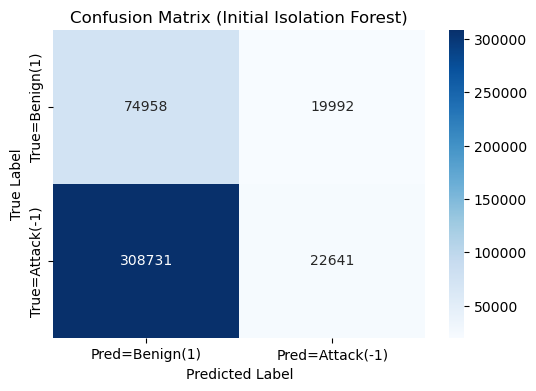


[Threshold Optimization] Best threshold: 0.1354
[Threshold Optimization] Best F1 score: 0.8747

[Best Threshold Applied] Confusion Matrix:
[[     0  94950]
 [     1 331371]]

[Best Threshold Applied] Classification Report:
              precision    recall  f1-score   support

  Benign (1)       0.78      1.00      0.87    331372
 Attack (-1)       0.00      0.00      0.00     94950

    accuracy                           0.78    426322
   macro avg       0.39      0.50      0.44    426322
weighted avg       0.60      0.78      0.68    426322



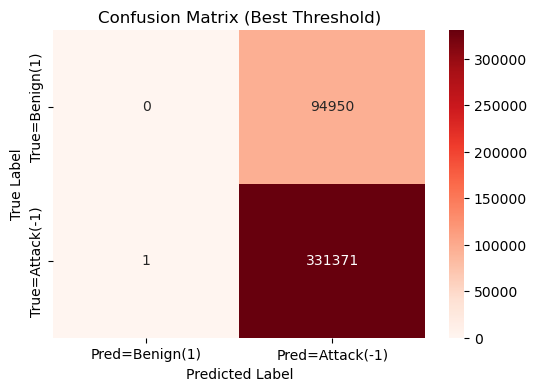


[Contamination Grid Search] In progress...


100%|██████████| 49/49 [01:26<00:00,  1.78s/it]



[Contamination Grid Search] Best contamination = 0.49
[Contamination Grid Search] Best F1 = 0.4658

[Best Contamination Applied] Confusion Matrix:
[[ 12067  82883]
 [205605 125767]]

[Best Contamination Applied] Classification Report:
              precision    recall  f1-score   support

  Benign (1)       0.60      0.38      0.47    331372
 Attack (-1)       0.06      0.13      0.08     94950

    accuracy                           0.32    426322
   macro avg       0.33      0.25      0.27    426322
weighted avg       0.48      0.32      0.38    426322



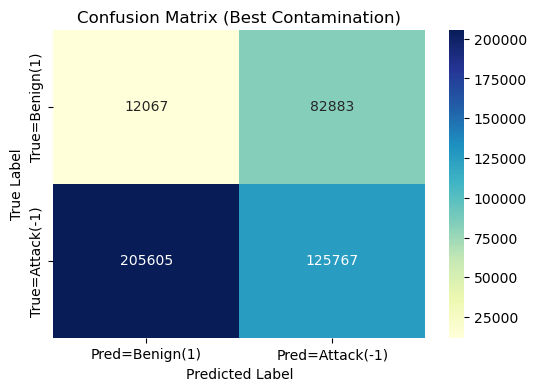

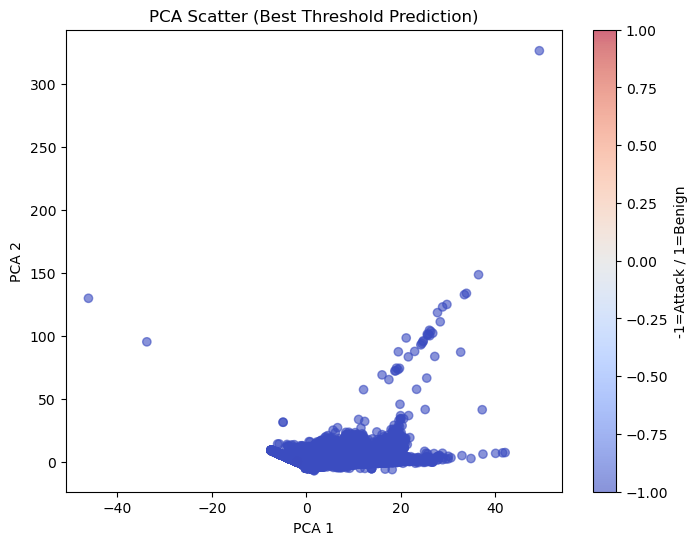

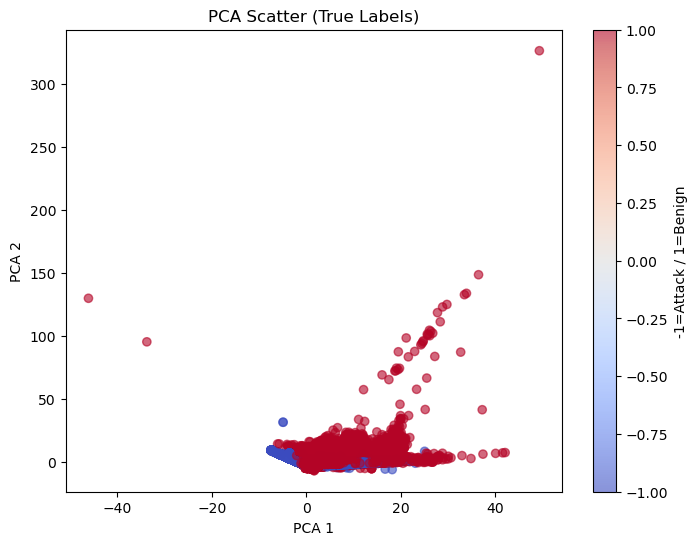

In [1]:
import glob
import pandas as pd
import numpy as np

#--- Libraries for visualization, preprocessing, and modeling ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm import tqdm

#####################################################
# 1) Load Data and Preprocessing                   #
#####################################################
train_files = glob.glob("../data/*training.parquet")
test_files  = glob.glob("../data/*testing.parquet")

df_list = []
for f in train_files:
    temp = pd.read_parquet(f)
    temp['set_type'] = 'train'
    df_list.append(temp)
for f in test_files:
    temp = pd.read_parquet(f)
    temp['set_type'] = 'test'
    df_list.append(temp)

df_all = pd.concat(df_list, ignore_index=True)
print("Initial full dataset size:", df_all.shape)

#--- Remove Missing Values & Duplicates ---
df_all.dropna(inplace=True)
df_all.drop_duplicates(inplace=True)
print("Size after removing missing values/duplicates:", df_all.shape)

#####################################################
# 2) Feature Scaling                                #
#####################################################
# - Isolation Forest does not use Label, set_type, etc., since it is unsupervised.
feature_columns = df_all.columns.difference(['Label', 'set_type'])
X = df_all[feature_columns].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#####################################################
# 3) Basic Training & Prediction using Isolation Forest
#####################################################

iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_scaled)

df_all['anomaly'] = iso_forest.predict(X_scaled)
print("Isolation Forest:")
print(df_all['anomaly'].value_counts())

#####################################################
# 4) Confusion Matrix + Classification Report + Visualization
#####################################################
# 4-1) Convert true labels to binary (1: Benign, -1: Attack)
df_all['true_binary'] = df_all['Label'].apply(lambda x: 1 if x == 'Benign' else -1)

# 4-2) Confusion Matrix & Report
cm_initial = confusion_matrix(df_all['true_binary'], df_all['anomaly'], labels=[1, -1])
print("\n[Initial Model] Confusion Matrix (Rows: True, Columns: Predicted):")
print(cm_initial)

print("\n[Initial Model] Classification Report:")
print(classification_report(df_all['true_binary'], df_all['anomaly'],
                            target_names=["Benign (1)", "Attack (-1)"]))

# 4-3) Visualize Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_initial, annot=True, cmap='Blues', fmt='g',
            xticklabels=["Pred=Benign(1)", "Pred=Attack(-1)"],
            yticklabels=["True=Benign(1)", "True=Attack(-1)"])
plt.title("Confusion Matrix (Initial Isolation Forest)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

#####################################################
# 5) Optimize F1 Score based on Threshold           #
#####################################################
# - Use IsolationForest's decision_function to get anomaly scores
# - Lower scores indicate a higher likelihood of anomaly
scores = iso_forest.decision_function(X_scaled)

thresholds = np.linspace(scores.min(), scores.max(), 100)
best_threshold = None
best_f1 = 0

for t in thresholds:
    # If score is less than threshold, label as -1 (anomaly), otherwise 1 (normal)
    pred_temp = np.where(scores < t, -1, 1)
    current_f1 = f1_score(df_all['true_binary'], pred_temp, pos_label=-1)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = t

print(f"\n[Threshold Optimization] Best threshold: {best_threshold:.4f}")
print(f"[Threshold Optimization] Best F1 score: {best_f1:.4f}")

# Final prediction using best_threshold
df_all['anomaly_best_thr'] = np.where(scores < best_threshold, -1, 1)

# Confusion Matrix & Report
cm_best_thr = confusion_matrix(df_all['true_binary'], df_all['anomaly_best_thr'], labels=[1, -1])
print("\n[Best Threshold Applied] Confusion Matrix:")
print(cm_best_thr)

print("\n[Best Threshold Applied] Classification Report:")
print(classification_report(df_all['true_binary'], df_all['anomaly_best_thr'],
                            target_names=["Benign (1)", "Attack (-1)"]))

# Visualize Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_best_thr, annot=True, cmap='Reds', fmt='g',
            xticklabels=["Pred=Benign(1)", "Pred=Attack(-1)"],
            yticklabels=["True=Benign(1)", "True=Attack(-1)"])
plt.title("Confusion Matrix (Best Threshold)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

#####################################################
# 6) Contamination Grid Search (Optional)          #
#####################################################
# - You can also optimize the F1 score by changing the contamination value.
best_contamination = None
best_f1_grid = 0
results = []

print("\n[Contamination Grid Search] In progress...")
for cont in tqdm(np.arange(0.01, 0.5, 0.01)):
    iso_temp = IsolationForest(contamination=cont, random_state=42)
    iso_temp.fit(X_scaled)
    preds_temp = iso_temp.predict(X_scaled)
    
    # Calculate F1 (treat Attack (-1) as positive)
    current_f1 = f1_score(df_all['true_binary'], preds_temp, pos_label=-1)
    results.append((cont, current_f1))
    
    if current_f1 > best_f1_grid:
        best_f1_grid = current_f1
        best_contamination = cont

print(f"\n[Contamination Grid Search] Best contamination = {best_contamination:.2f}")
print(f"[Contamination Grid Search] Best F1 = {best_f1_grid:.4f}")

# Train IsolationForest again using the best contamination
iso_best_cont = IsolationForest(contamination=best_contamination, random_state=42)
iso_best_cont.fit(X_scaled)
preds_best_cont = iso_best_cont.predict(X_scaled)

cm_best_cont = confusion_matrix(df_all['true_binary'], preds_best_cont, labels=[1, -1])
print("\n[Best Contamination Applied] Confusion Matrix:")
print(cm_best_cont)

print("\n[Best Contamination Applied] Classification Report:")
print(classification_report(df_all['true_binary'], preds_best_cont,
                            target_names=["Benign (1)", "Attack (-1)"]))

# Visualization
plt.figure(figsize=(6,4))
sns.heatmap(cm_best_cont, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=["Pred=Benign(1)", "Pred=Attack(-1)"],
            yticklabels=["True=Benign(1)", "True=Attack(-1)"])
plt.title("Confusion Matrix (Best Contamination)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

#####################################################
# 7) (Optional) PCA Visualization Example           #
#####################################################
# Using the already scaled data X_scaled
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# (1) Visualize best_threshold prediction results using color coding
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=df_all['anomaly_best_thr'], cmap='coolwarm', alpha=0.6)
plt.title('PCA Scatter (Best Threshold Prediction)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='-1=Attack / 1=Benign')
plt.show()

# (2) Visualize true labels (true_binary) using color coding
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=df_all['true_binary'], cmap='coolwarm', alpha=0.6)
plt.title('PCA Scatter (True Labels)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='-1=Attack / 1=Benign')
plt.show()
